In [1]:
from fastai.vision.all import *

In [2]:
#--------------------READ & VISUALIZE--------------------#

In [3]:
path = untar_data(URLs.MNIST_SAMPLE) #path to a local MNIST library
#(path/'train').ls() 
(path).ls() #path contains mnist_sample folder, which has a csv file, train and valid folders

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
#threes

In [5]:
#output an image of 3
img3_path = threes[6]
img3 = Image.open(img3_path)

img3

In [6]:
#translate an image to tensor, so that computer will understand what is it
img3_t = tensor(img3)

df = pd.DataFrame(img3_t[4:15,4:22]) #plot one region
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys') #plot with grey colors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,61,177,254,255,153,118,118,118,6,0,0,0,0
2,0,71,234,234,234,244,253,253,253,253,253,253,253,179,66,0,0,0
3,0,191,253,253,253,214,177,177,239,253,253,253,253,253,170,0,0,0
4,0,109,181,61,61,30,0,0,50,61,150,229,253,253,233,41,0,0
5,0,25,20,0,0,0,0,0,0,0,0,144,253,253,253,54,0,0
6,0,0,0,0,0,0,0,0,0,0,9,150,253,253,204,22,0,0
7,0,0,0,0,0,0,0,0,0,97,210,253,253,253,170,0,0,0
8,0,0,0,0,0,0,108,233,248,252,253,253,253,208,22,0,0,0
9,0,0,0,0,5,160,253,253,253,253,253,253,253,186,12,0,0,0


In [7]:
#--------------------AVG OF 3's & 7's--------------------#

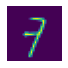

In [8]:
# create a list of tensors (hard way)
# three_tensors = []
# for i in threes:
#     three_tensors.append(tensor(Image.open(i)))


# create a list of tensors (easy, list comprehension, way)
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

show_image(seven_tensors[100]);

In [9]:
#stacking all images into one big tensor of shape 28*28
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

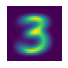

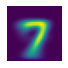

In [10]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
show_image(mean3);
show_image(mean7);

In [11]:
#--------------------CALCULATING METRICS--------------------#

In [12]:
#pick a random 3, and compare it to ideal 3
a_3 = stacked_threes[999]

dist_3_abs = (a_3 - mean3).abs().mean()       #mean absolute difference, L1 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() #root mean squared error, L2 norm

print('L1 norm is: {}, L2 norm is: {}'.format(dist_3_abs,dist_3_sqr))

L1 norm is: 0.1194072961807251, L2 norm is: 0.2177300900220871


In [13]:
#using PyTorch built in methods
F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()

(tensor(0.1194), tensor(0.2177))

In [14]:
#--------------------VALIDATION--------------------#

In [15]:
#loading validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [16]:
#function that compares an tensor with an ideal tensor
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
#(a-b).abs()    - absolute value of the difference between ideal tensor and the tensor of comparison
#.mean((-1,-2)) - -1 is the last axis, -2 is second to last. Here we averaged the intensity of all the pixels in one image

mnist_distance(a_3, mean3)

tensor(0.1194)

In [17]:
#validate results of out model with images from validation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
#PyTorch automatically applies broadcasting, 
#pretending that mean3(28,28) is a shape 1010 tensor, and (valid_3_tens - mean3) has the shape [1010,28,28]

valid_3_dist, valid_3_dist.shape

(tensor([0.1270, 0.1632, 0.1676,  ..., 0.1228, 0.1210, 0.1287]),
 torch.Size([1010]))

In [18]:
#--------------------CALCULATING ACCURACY--------------------#

In [19]:
#return 'is 3' is distance of 
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [20]:
#calculate accuracy
accuracy_3s = is_3(valid_3_tens).float() .mean()      #output True if a tensor is 3, transfer to boolean, calculate mean
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean() #same as previous, 1- is for switching results

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [21]:
#--------------------MNIST LOST FUNCTION--------------------#

In [22]:
#concatenate xs (images) into a single vector,
#and change them from rank-3 tensor (matrix) into rank-2 tensor (vector)
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)

#labels for each image
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [23]:
#zip x and y together into one dataset
dset = list(zip(train_x, train_y))
x, y = dset[0] #first element of the dataset

x.shape, y

(torch.Size([784]), tensor([1]))

In [24]:
#do the same thing to validation set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [25]:
#random weights and biases for every pixel
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

#set weights for one element, shape: ([784, 1])
weights = init_params((28*28, 1))
#set biases for one element,  shape: ([1])
bias = init_params(1)

In [26]:
#calculate prediction for onw image
(train_x[0]*weights.T).sum() + bias

tensor([6.5849], grad_fn=<AddBackward0>)

In [27]:
#use matrix multiplication to calculate predictions
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ 6.5849],
        [-6.3284],
        [12.3333],
        ...,
        [ 7.7937],
        [10.3930],
        [ 4.3589]], grad_fn=<AddBackward0>)

In [28]:
corrects = (preds>0.0).float() == train_y
corrects.float().mean().item()

0.3624556362628937

In [29]:
#--------------------LOSS FUNCTION--------------------#

In [30]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1,  1-predictions, predictions).mean()
    
#.where(a,b,c) returns [b[i] if a[i] else c[i] for i in range(len(a))]

In [31]:
#example
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

torch.where(trgts==1, 1-prds, prds)
#lower the value, higher the certainty

tensor([0.1000, 0.4000, 0.8000])

In [32]:
#calculte loss
mnist_loss(prds, trgts)

tensor(0.4333)

In [33]:
#to ensure that predictions are always 0 or 1, we apply sigmoid function
#from fastbook import *
#plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [34]:
#sigmoid function
def sigmoid(x): 
    return 1/(1+torch.exp(-x))

#lost function with sigmoid
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [35]:
#--------------------BATCHING--------------------#

In [36]:
#We can calculate loss over the whole dataset and take the average (too much time), 
#or for single elements (not use enough info), but neither are the best practice

#Therefore, we calculate loss for a small batch of data
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 6,  7, 12,  8,  5]),
 tensor([ 1, 14,  0, 10,  2]),
 tensor([13,  4,  3, 11,  9])]

In [37]:
#to illustra how DataLoader works, we use dataset
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [38]:
#after passing it to dataloader, we have:
dl = DataLoader(ds, batch_size=4, shuffle=True)
list(dl)

[(tensor([12,  8,  4, 17]), ('m', 'i', 'e', 'r')),
 (tensor([14,  5,  1, 19]), ('o', 'f', 'b', 't')),
 (tensor([22, 24,  2,  3]), ('w', 'y', 'c', 'd')),
 (tensor([13, 20, 11, 23]), ('n', 'u', 'l', 'x')),
 (tensor([16,  0, 15,  6]), ('q', 'a', 'p', 'g')),
 (tensor([ 9, 18, 10,  7]), ('j', 's', 'k', 'h')),
 (tensor([21, 25]), ('v', 'z'))]

In [39]:
#--------------------PUTTING IT ALL TOGETHER--------------------#

In [40]:
#reinitializing parameters
weights = init_params((28*28), 1)
bias    = init_params(1)

In [41]:
#creating dataloader for dataset
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl) #first element in the dataloader
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [42]:
#creating dataloader for validation set
valid_dl = DataLoader(valid_dset, batch_size=256)

#creating mini-batch for testing
batch = train_x[:4] #size([4, 784])

In [43]:
def calc_grad(xb, yb, model):
    preds = model(xb)            #testing
    loss = mnist_loss(preds, yb) #calculating loss
    loss.backward()              #calculate gradients
    
calc_grad(batch, train_y[:4], linear1)
print(weights.grad.mean(),bias.grad)

#if you run calc_grad twice, because loss.backward adds the gradients 
#of loss to any gradients that are currently stored
weights.grad.zero_()
bias.grad.zero_()

tensor(-3.0423e-05) tensor([-0.0002])


tensor([0.])

In [44]:
#update w and b based on gradient and learning rate
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
    for p in params:
        p.data -= p.grad*lr
        p.grad.zero_()

In [45]:
#calculate validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [46]:
#output accuracy after 1 epoch
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [47]:
#starting point
validate_epoch(linear1)

0.5097

In [48]:
#run for 1 epoch
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6295

In [49]:
#run for 20 more 
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4937 0.4947 0.4956 0.5684 0.9435 0.9457 0.9452 

In [50]:
#--------------------OPTIMIZER--------------------#

In [51]:
#because this is a very general implementation, we can find
#all the implementation in PyTorch
linear_model = nn.Linear(28*28, 1) #linear function
w, b = linear_model.parameters()   #parameters of the model

w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [55]:
#creating optimizer
class BasicOptimizer:
    def __init__(self, params, lr): self.params,self.lr = list(params),lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data*self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
            
opt = BasicOptimizer(linear_model.parameters(), lr)

In [56]:
#training loop
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [57]:
validate_epoch(linear_model)

0.7723

In [60]:
#simplifying the process
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')
        
train_model(linear_model, 20)

0.4932 0.7929 0.8593 0.9179 0.936 0.9492 0.9565 0.9638 0.9658 0.9682 0.9702 0.9726 0.9745 0.9745 0.976 0.9775 0.9775 0.978 0.9785 0.9785 

In [61]:
#BasicOptimizer could be replaced by PyTorch builtin SDG
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8867 0.8227 0.9101 0.9321 0.9458 0.954 0.9619 0.9653 0.9672 0.9692 0.9711 0.9736 0.975 0.9755 0.9765 0.9775 0.9785 0.9785 0.9789 

In [62]:
#we could also replace Learner.fit instead of train_model,
#but it works with dataloaders

dls = DataLoaders(dl, valid_dl)
learn = Learner(dls,                    #data in dataloader
                nn.Linear(28*28,1),     #linear function
                opt_func=SGD,           #stochastic gradient descent
                loss_func=mnist_loss,   #loss function
                metrics=batch_accuracy) #metrics

learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637007,0.503431,0.495584,00:00
1,0.499687,0.193837,0.838567,00:00
2,0.184216,0.181215,0.837586,00:00
3,0.081224,0.106771,0.911678,00:00
4,0.043265,0.077952,0.932287,00:00
5,0.028424,0.062412,0.947498,00:00
6,0.022312,0.052729,0.954858,00:00
7,0.019589,0.046293,0.962218,00:00
8,0.018206,0.041780,0.965162,00:00
9,0.017377,0.038462,0.966143,00:00
